In [1]:
import face_alignment
from skimage import io
import pygame

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt

import numpy as np 

from PIL import Image
from torchvision import transforms

pygame 2.0.0 (SDL 2.0.12, python 3.7.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class GazeNet(nn.Module):

    def __init__(self, device):    
        super(GazeNet, self).__init__()
        self.device = device
        self.preprocess = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        model = models.mobilenet_v2(pretrained=True)
        model.features[-1] = models.mobilenet.ConvBNReLU(320, 256, kernel_size=1)
        self.backbone = model.features

        self.Conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.Conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.Conv3 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1, padding=0)

        self.fc1 = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )   
        self.fc_final = nn.Linear(512, 2)

        self._initialize_weight()
        self._initialize_bias()
        self.to(device)


    def _initialize_weight(self):
        nn.init.normal_(self.Conv1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.Conv2.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.Conv3.weight, mean=0.0, std=0.001)

    def _initialize_bias(self):
        nn.init.constant_(self.Conv1.bias, val=0.1)
        nn.init.constant_(self.Conv2.bias, val=0.1)
        nn.init.constant_(self.Conv3.bias, val=1)

    def forward(self, x):
        
        x = self.backbone(x)
        y = F.relu(self.Conv1(x))
        y = F.relu(self.Conv2(y))
        y = F.relu(self.Conv3(y))
        
        x = F.dropout(F.relu(torch.mul(x, y)), 0.5)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        gaze = self.fc_final(x)

        return gaze

    def get_gaze(self, img):
        img = Image.fromarray(img)
        img = self.preprocess(img)[np.newaxis,:,:,:]
        x = self.forward(img.to(self.device))
        return x

In [3]:
def get_area_of_triangle(x1, y1, x2, y2, x3, y3):
    return abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2)) / 2

def get_area_of_rectangle(x1, y1, x2, y2, x3, y3, x4, y4):
    return (get_area_of_triangle(x1, y1, x2, y2, x3, y3) + 
           get_area_of_triangle(x1, y1, x2, y2, x4, y4) +
           get_area_of_triangle(x1, y1, x3, y3, x4, y4) +
           get_area_of_triangle(x2, y2, x3, y3, x4, y4)) / 2

In [4]:
def get_offset(img, model, faceCascade):
    img_cp = img.copy()
    gray = cv2.cvtColor(img_cp, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )
    
    x_s, y_s = 0, 0
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        origins = [(x + w//2, y + h//3)]
        new_img=img_cp[y:y+h,x:x+w]
        for face, gaze_origin in zip(faces, origins):
            with torch.no_grad():
                gaze = model.get_gaze(new_img)
                gaze = gaze[0].data.cpu()
                eye_pos = gaze_origin
                pitchyaw = gaze
                length=200

                dx = -length * np.sin(pitchyaw[1])
                dy = -length * np.sin(pitchyaw[0])
                x_s=tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int))[0]-tuple(np.round(eye_pos).astype(np.int32))[0]
                y_s=tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int))[1]-tuple(np.round(eye_pos).astype(np.int32))[1]
    return x_s, y_s

In [5]:
def show_image(image, dots=[]):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.scatter(
        x=[x for (x,y) in dots],
        y=[y for (x,y) in dots],
        color="orange"
    )
    plt.axis("off")
    plt.show()

In [6]:
def get_predictions(img):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')
    preds = fa.get_landmarks(img)

    fig=plt.figure(figsize=(20, 20))
    #for detection in preds:
     #   plt.scatter(detection[36:42,0], detection[36:42,1], 2)
     #   plt.scatter(detection[42:48,0], detection[42:48,1], 2)

    for detection in preds:
        preds1=detection
    
    return preds1
    

def get_eyes(img, preds, show=False):
    img_cp = img.copy()
    

    left_eye=img[int(min(preds[36:42, 1])) - 25:int(max(preds[36:42, 1])) + 25,int(min(preds[36:42, 0])):int(max(preds[36:42, 0]))]
    right_eye=img[int(min(preds[42:48, 1])) - 25:int(max(preds[42:48, 1])) + 25,int(min(preds[42:48, 0])):int(max(preds[42:48, 0]))]
    
    if show:
        show_image(left_eye)
        show_image(right_eye)
    return left_eye, right_eye



In [7]:
def open_eye(eye, offset, show=False):
    
    img = eye.copy()
    nh, nw = img.shape[:2]
    PI = 3.141592653589793
    phase = 1 * PI
    omega = 1.0 * PI / nw
    amp = -4

    xs, ys = np.meshgrid(np.arange(0, nw), np.arange(0, nh))
    xs1, ys1 = np.meshgrid(np.arange(0, nw), np.arange(0, nh // 2))
    xs2, ys2 = np.meshgrid(np.arange(0, nw), np.arange(nh // 2, nh))
    ys1 = np.sin(phase+xs1*omega)*(-10) + ys1
    ys2 = np.sin(phase+xs2*omega)*(10) + ys2
    xs = np.float32(xs)
    ys = np.float32(np.concatenate((ys1,ys2),axis=0))

    dst = cv2.remap(img, xs, ys, cv2.INTER_CUBIC)
    if show:
        show_image(img)
        show_image(dst)
    return dst

In [8]:
def add_eye_to_photo(img, preds, left_eye, right_eye, show=False):
    img_cp = img.copy()

    img_cp[int(min(preds[36:42, 1])) - 25:int(max(preds[36:42, 1])) + 25,int(min(preds[36:42, 0])):int(max(preds[36:42, 0]))] = left_eye
    img_cp[int(min(preds[42:48, 1])) - 25:int(max(preds[42:48, 1])) + 25,int(min(preds[42:48, 0])):int(max(preds[42:48, 0]))] = right_eye

    if show:
        show_image(img_cp)
    return img_cp

In [9]:
def preprocess():
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = GazeNet(device)
    state_dict = torch.load('gazenet.pth', map_location=device)
    model.load_state_dict(state_dict)
    
    return model, faceCascade

In [10]:
def calc_square(preds):
    s1_l = get_area_of_triangle(preds[36:37, 0],preds[36:37, 1],preds[37:38,0],preds[37:38,1],preds[41:42,0],preds[41:42,1])
    s2_l = get_area_of_triangle(preds[38:39, 0],preds[38:39, 1],preds[39:40,0],preds[39:40,1],preds[40:41,0],preds[40:41,1])
    s12_l = get_area_of_rectangle(preds[37:38,0],preds[37:38,1],preds[38:39, 0],preds[38:39, 1],preds[40:41,0],preds[40:41,1],preds[41:42,0],preds[41:42,1])
    s1_r = get_area_of_triangle(preds[42:43, 0],preds[42:43, 1],preds[43:44,0],preds[43:44,1],preds[47:48,0],preds[47:48,1])
    s2_r = get_area_of_triangle(preds[44:45, 0],preds[44:45, 1],preds[45:46,0],preds[45:46,1],preds[46:47,0],preds[46:47,1])
    s12_r = get_area_of_rectangle(preds[43:44,0],preds[43:44,1],preds[44:45, 0],preds[44:45, 1],preds[46:47,0],preds[46:47,1],preds[47:48,0],preds[47:48,1])
    s_left=s1_l[0]+s2_l[0]+s12_l[0]
    s_right=s1_r[0]+s2_r[0]+s12_r[0]
    
    return s_left, s_right

In [11]:
def calc_metric(img_c, predictions_c, final_image_c):
    img = img_c.copy()
    s_left_be, s_right_be = calc_square(predictions_c)
    final_image = final_image_c.copy()
    preds2 = get_predictions(final_image)
    s_left_af, s_right_af = calc_square(preds2)
    s = [s_left_af/s_left_be, s_right_af/s_right_be]
    return s

In [12]:
def change_face(img, model, faceCascade):
    offset = get_offset(img, model, faceCascade)
    predictions = get_predictions(img)
    left_eye, right_eye = get_eyes(img, predictions, False)
    left_opened = open_eye(left_eye, 5)
    right_opened = open_eye(right_eye, 5)
    final_image = add_eye_to_photo(img, predictions, left_opened, right_opened, False)
    metric = calc_metric(img, predictions, final_image)
    return final_image, metric

In [13]:
def make_life(model, faceCascade):
    webcam = cv2.VideoCapture(0)

    while True:
        # We get a new frame from the webcam
        _, frame = webcam.read()
        final_face = change_face(frame, model,faceCascade)

        cv2.imshow("Demo", final_face)

        if cv2.waitKey(1) == 27:
            break

[0.9488904, 1.0674962]


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

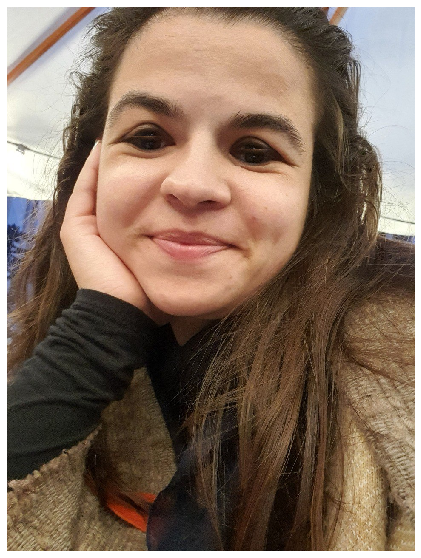

In [14]:
model, faceCascade = preprocess()
image_url = 'cvk.jpg'
img = cv2.imread(image_url)

final_face, metric = change_face(img, model,faceCascade)

print(metric)
show_image(final_face)